Goal of this notebook is to create a plain feed forward NNs with the MNIST dataset using numpy alone. Kera is only used for image augmentation and loading the MNIST library. 

In [1]:
# Load the main library needed for this assignment
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# Data Preparation
* Load MNIST dataset from keras
* Flatten and normalize the grayscale by dividing by 255 on the testing data (performed on the training data after image augmentation)
* One-hot encode training and testing labels

In [136]:
from keras.datasets import mnist

# Load MNIST dataset from keras
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Number of samples
n = 10000
random_index = np.random.randint(n, size=n) # Randomly select training data
images, labels = (X_train[random_index], Y_train[random_index])

# Convert train label into one-hot encoding
train_labels = np.zeros((len(labels),10))
for i,l in enumerate(labels):
    train_labels[i][l] = 1

# Flatten the testing data 
test_images = X_test.reshape(len(X_test),28*28)
test_images = test_images/255 # If Normalization

# If Standarization (doesn't do as well as normalization)
#test_images = (test_images - np.mean(test_images))/ np.std(test_images)

test_labels = np.zeros((len(Y_test),10)) # one-hot encode test labels
for i,l in enumerate(Y_test):
    test_labels[i][l] = 1

print(f'Train Data: {images.shape}, Train Label: {train_labels.shape}, Test Data: {test_images.shape}, Test Label: {test_labels.shape}')

Train Data: (10000, 28, 28), Train Label: (10000, 10), Test Data: (10000, 784), Test Label: (10000, 10)


### Visualization

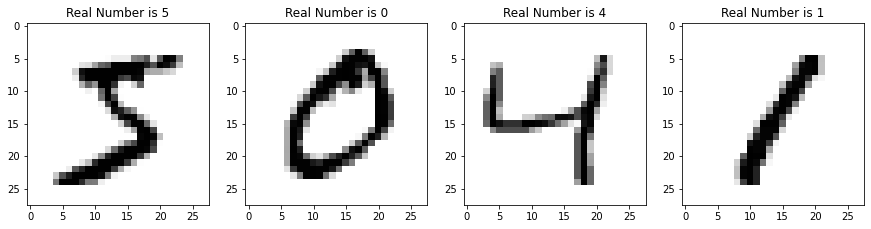

In [137]:
fig, axis = plt.subplots(1, 4, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train[i], cmap='binary')
    digit = Y_train[i]
    ax.set(title = f"Real Number is {digit}");

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


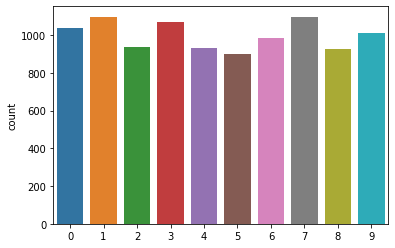

In [138]:
# Distribution of training labels
sns.countplot(Y_train[random_index])

### Image Augmentation
* Perform augmentation on training dataset to prevent overfitting
* Make use of Keras Preprocessing Image Techniques: 
    - Random Rotation
    - Random Shift
    - Random Shear
* Flatten and normalize the grayscale by dividing by 255 on the augmented training data

In [145]:
# Code from Kaggle Notebook - Easy Image Augmentation Techniques for MNIST
# Source: https://www.kaggle.com/dhayalkarsahilr/easy-image-augmentation-techniques-for-mnist

def augment_data(dataset, dataset_labels, augementation_factor=1, use_random_rotation=True, use_random_shear=True, use_random_shift=True, use_random_zoom=True):
  augmented_image = []
  augmented_image_labels = []

  for num in range (0, dataset.shape[0]):

    for i in range(0, augementation_factor):
      # original image:
      augmented_image.append(dataset[num])
      augmented_image_labels.append(dataset_labels[num])

    if use_random_rotation:
      augmented_image.append(tf.keras.preprocessing.image.random_rotation(dataset[num], 20, row_axis=0, col_axis=1, channel_axis=2))
      augmented_image_labels.append(dataset_labels[num])

    if use_random_shear:
      augmented_image.append(tf.keras.preprocessing.image.random_shear(dataset[num], 20, row_axis=0, col_axis=1, channel_axis=2))
      augmented_image_labels.append(dataset_labels[num])

    if use_random_shift:
      augmented_image.append(tf.keras.preprocessing.image.random_shift(dataset[num], 0.2, 0.2, row_axis=0, col_axis=1, channel_axis=2))
      augmented_image_labels.append(dataset_labels[num])

  return np.array(augmented_image), np.array(augmented_image_labels)

In [146]:
images_expand = np.expand_dims(images,3) # Reshape input to have rank 4 for augmentation
train_images, train_labels = augment_data(images_expand, train_labels, augementation_factor=1)

# Flatten and Normalize the training augmented dataset
train_images = train_images.reshape(len(train_images),28*28)/255

print(f'New Augmented Train Data: {train_images.shape}, New Augmented Train Label: {train_labels.shape}')

New Augmented Train Data: (40000, 784), New Augmented Train Label: (40000, 10)


<Figure size 432x288 with 0 Axes>

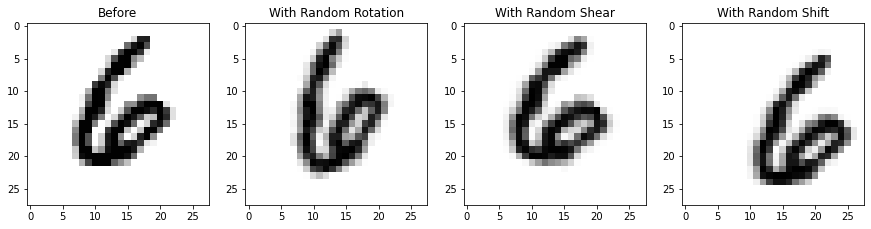

In [151]:
sample_image = X_train[13:14]
sample = augment_data(np.expand_dims(sample_image,3), Y_train[13:14], augementation_factor=1)

plt.figure()
f, ax = plt.subplots(1,4,figsize=(15, 10))
ax[0].imshow(sample_image[0], cmap='binary')
ax[0].set_title('Before')
ax[1].imshow(np.squeeze(sample[0][1],axis=2), cmap='binary')
ax[1].set_title('With Random Rotation')
ax[2].imshow(np.squeeze(sample[0][2],axis=2), cmap='binary')
ax[2].set_title('With Random Shear')
ax[3].imshow(np.squeeze(sample[0][3],axis=2), cmap='binary')
ax[3].set_title('With Random Shift')
plt.show()

# Building 4 layer Feed Forward NN with pure Numpy

### Loss Function

In [19]:
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    # print('MSE backward', self.y_pred.shape, self.y_true.shape, self.gradient.shape)
    return self.gradient

### Activation Function

In [20]:
class Relu:
    def __call__(self, input_):
      self.input_ = input_
      self.output = np.clip(self.input_, 0, None)
      return self.output
    
    def backward(self, output_gradient):
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient

### Linear Model
* Initialize the random weights of network properly
* Compute forward pass and calculate the gradient for backward pass
* Update weights and bias


In [21]:
class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = np.random.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
    self.bias = np.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = x @ self.weights + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = self.x.T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

### Dropout

A regularization method of randomly turning off neruours during training. Prevent overfitting by enforcing the neural network to train exclusively using random subsections (smaller network) of the neural network.
* Make use of Bernoulli distribution s.t. for a rate of 80%, each value in dropout_mask is 1 and 20% of the time, it's 0. 

In [22]:
class Dropout:
  def __init__(self, rate):
    self.rate = rate

  def __call__(self, inputs):
    dropout_mask = np.random.binomial(1,self.rate,size=inputs.shape)/self.rate
    return inputs * dropout_mask

### Model Configuration

In [23]:
from typing import Callable

class Model:

  # Configure model
  def __init__(self, input_dim, num_hidden):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu1 = Relu()
    self.dropout1 = Dropout(0.5)
    self.linear2 = Linear(num_hidden,200) 
    self.relu2 = Relu()
    self.dropout2 = Dropout(0.5)
    self.linear3 = Linear(200,80)
    self.relu3 = Relu()
    self.dropout3 = Dropout(0.5)
    self.linear4 = Linear(80,10)
  
  # Forward pass
  def __call__(self, x, training = None):
    l1 = self.linear1(x)
    r1 = self.relu1(l1)
    if training:
      r1 = self.dropout1(r1) # Add dropout
    l2 = self.linear2(r1)
    r2 = self.relu2(l2)
    if training:
      r2 = self.dropout2(r2) # Add dropout
    l3 = self.linear3(r2)
    r3 = self.relu3(l3)
    if training:
      r3 = self.dropout3(r3) # Add dropout
    l4 = self.linear4(r3)
    return l4
  
  # Backward pass
  def backward(self, output_gradient):
    linear4_gradient = self.linear4.backward(output_gradient)
    relu3_gradient = self.relu3.backward(linear4_gradient)
    linear3_gradient = self.linear3.backward(relu3_gradient)
    linear3_gradient = self.dropout3(linear3_gradient) # Add dropout
    relu2_gradient = self.relu2.backward(linear3_gradient)
    linear2_gradient = self.linear2.backward(relu2_gradient)
    linear2_gradient = self.dropout2(linear2_gradient) # Add dropout
    relu1_gradient = self.relu1.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu1_gradient)
    linear1_gradient = self.dropout1(linear1_gradient) # Add dropout
    return linear1_gradient

  # Update learnable parameters
  def update(self, lr):
    self.linear4.update(lr)
    self.linear3.update(lr)
    self.linear2.update(lr)
    self.linear1.update(lr)

### Training and Testing
* Mini-batch gradient descent with appropriate learning rate

In [24]:
def train_on_batch(x, y, lr):
  y_pred = model(x)
  loss_value = loss(y_pred, y)
  gradient_from_loss = loss.backward()
  model.backward(gradient_from_loss)
  model.update(lr)
  return model

def eval_step(y, y_pred):
  tot_loss = loss(y,y_pred)
  pred, real = np.argmax(y_pred,1), np.argmax(y,1) # Argmax returns the indices of the max value
  accuracy = np.sum(pred == real)/len(y)
  return tot_loss, accuracy

In [14]:
def fit(x: np.ndarray, y: np.ndarray, x_test: np.ndarray, y_test: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int, batch_size=1):
  Train_Loss, Train_Acc, Test_Loss, Test_Acc = [], [], [], []
  for epoch in range(num_epochs):
    # Training by batches
    for i in range(int(len(x)/batch_size)):
      batch_start, batch_end = ((i * batch_size),((i+1)*batch_size))
      model = train_on_batch(x[batch_start:batch_end], y[batch_start:batch_end], lr)
    if epoch % 100 == 0:
      # Train Datset
      print('Epoch', epoch)
      train_loss, train_acc = eval_step(y, model(x, training=False))
      print(f'Train Loss {train_loss}, Train Accuracy {train_acc}')
      Train_Loss.append(train_loss)
      Train_Acc.append(train_acc)
      # Test Dateset
      test_loss, test_acc = eval_step(y_test, model(x_test, training=False))
      print(f'Test Loss {test_loss}, Test Accuracy {test_acc}')
      Test_Loss.append(test_loss)
      Test_Acc.append(test_acc)
      print()
  return Train_Loss, Train_Acc, Test_Loss, Test_Acc

# Define Learning Rate, Loss
loss = MSE() 
model = Model(784, 784) # Input dimension, Hidden dimension
Train_Loss, Train_Acc, Test_Loss, Test_Acc = fit(train_images, train_labels, test_images, test_labels, model=model, loss=loss, lr=0.016, num_epochs=401, batch_size=256)

Epoch 0
Train Loss 0.05537811960038574, Train Accuracy 0.6589333333333334
Test Loss 0.043257519381554414, Test Accuracy 0.8087

Epoch 100
Train Loss 0.006006138405862584, Train Accuracy 0.98655
Test Loss 0.008410461382414804, Test Accuracy 0.9726

Epoch 200
Train Loss 0.002598478762301712, Train Accuracy 0.9958166666666667
Test Loss 0.007862061172357774, Test Accuracy 0.9745

Epoch 300
Train Loss 0.0014193508162170924, Train Accuracy 0.99745
Test Loss 0.008012147941354745, Test Accuracy 0.9735

Epoch 400
Train Loss 0.0009027345017463167, Train Accuracy 0.9979166666666667
Test Loss 0.008211342552815968, Test Accuracy 0.9713



# Model Evaluation 

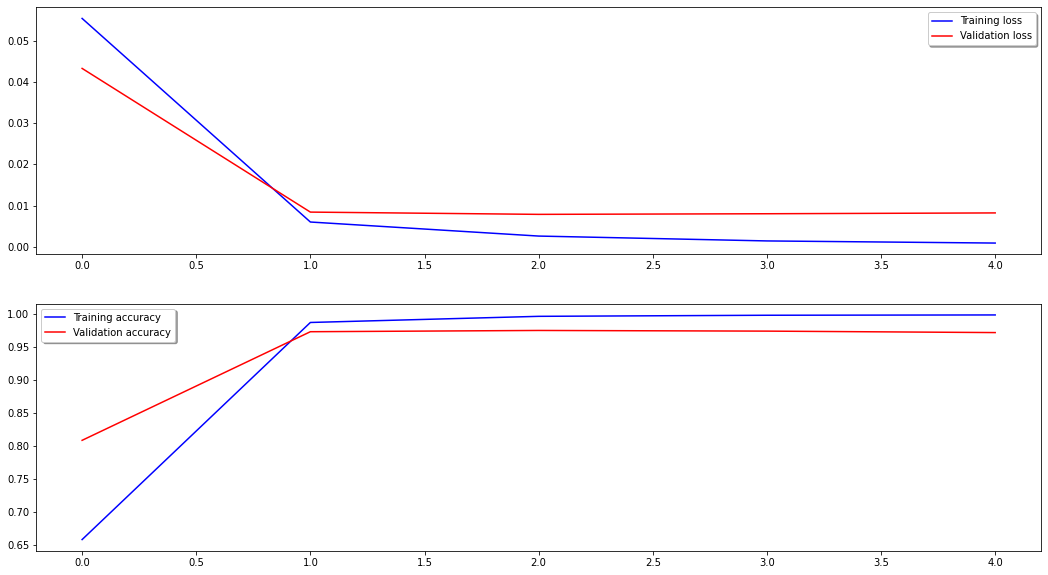

In [15]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(Train_Loss, color='b', label="Training loss")
ax[0].plot(Test_Loss, color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(Train_Acc, color='b', label="Training accuracy")
ax[1].plot(Test_Acc, color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Confusion Matrix for Test Data

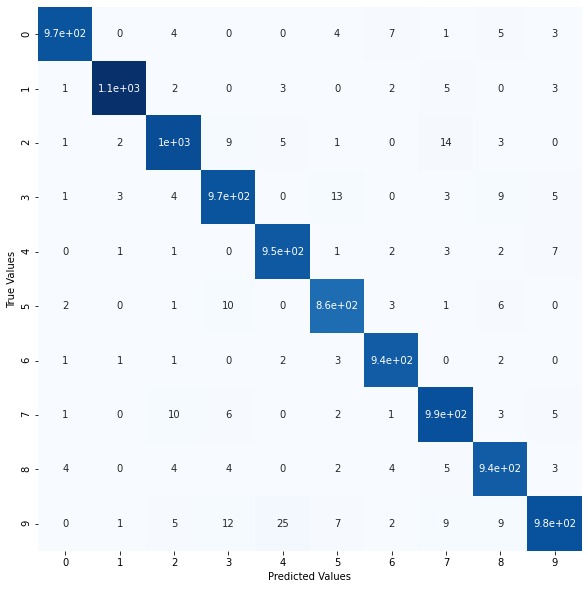

In [16]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model(test_images, training=False) # Predict encoded label as 2 => [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(test_labels, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

### Prediction Visualization

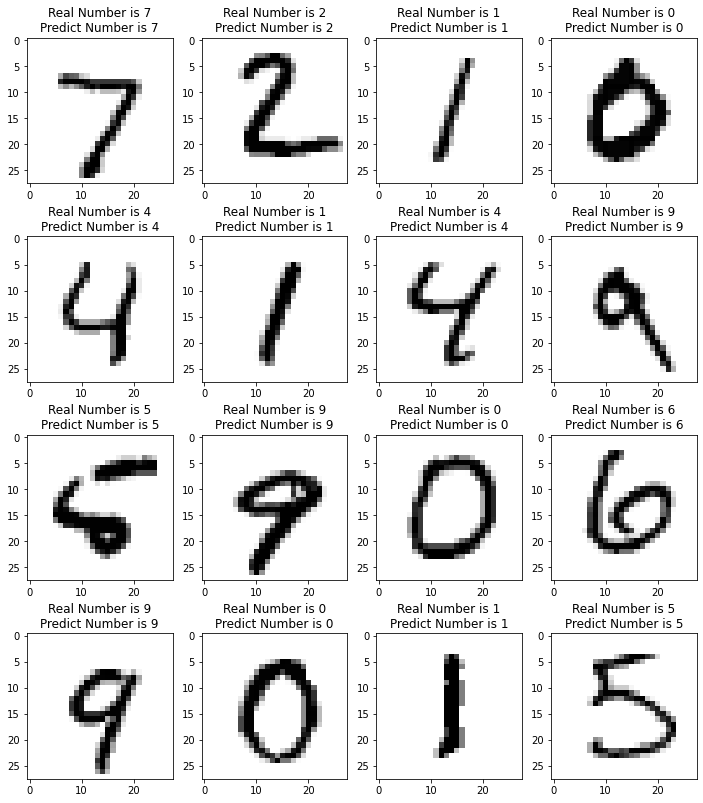

In [17]:
fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test[i], cmap='binary')
    ax.set(title = f"Real Number is {Y_test[i]}\nPredict Number is {Y_pred[i]}");